In [51]:
# zerando workspace
%reset -f

import bibtexparser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import codecs

from pathlib import Path
from pybtex.database import parse_file

### 1. Planejamento: Definição da Questão de Pesquisa

### 2. Planejamento: Desenvolvimento do Protocolo de Revisão

Bases de dados consultadas para exportação dos arquivos bibtex:

- OpenAlex - https://openalex.org/
- ACM Digital Library - http://dl.acm.org
- Elsevier Science Direct - https://www.sciencedirect.com/search/entry
- Engineering Village El Compendex - https://www.engineeringvillage.com
- IEEE Xplore Digital Library - https://ieeexplore.ieee.org
- Scopus - https://www.scopus.com/search/form.uri
- Web of Science - https://www.webofscience.com/wos/woscc/united-search
- ProQuest - https://www.proquest.com/
- Eric - https://eric.ed.gov/
- wiley - https://onlinelibrary.wiley.com/
- ebsco - https://www.ebsco.com/

Vale a pena incluir?

- https://doaj.org/

Bases não consultadas pois percebemos que os artigos começaram a se repetir:

- Taylor & Francis: https://www.tandfonline.com (só exporta para .csv)
- Springer: https://link.springer.com/ (só exporta para .csv)

Todos bibtext foram exportados na data: xx/xx/2024

String de busca aplicado somente no título e no resumo: <code>"Dashboard" AND "Learning Analytics" AND ("Systematic Literature Review" OR "Systematic Review")</code>

Aplicada somente no título e resumo

Problemas encontrados na exportação para bibtex de cada plataforma:

<br><b>OpenAlex:</b> <br>

Só exporta no formato ris. Com a biblioteca pybtexris convertemos para bibtex com o comando <code>pybtex-convert openalex.ris openalex.bib</code>. Por conta da duplicação das chaves no arquivos ris: 
<code>
WARNING: repeated bibliograhpy entry: Schwendimann2016                                                                                  
WARNING: repeated bibliograhpy entry: Kaliisa2023
</code>

Editei manualmente o arquivo ris, dupliquei a linha do autor (AU) de umas das entradas e criei uma linha com ID único:
<code>
AU  - Schwendimann, Beat
ID  - Schwendimann1 ---> Nova linha
...
AU  - Kaliisa, Rogers
ID  - Kaliisa1 ---> Nova linha
</code>

Com essas alterações o comando <code>pybtex-convert openalex.ris openalex.bib</code> foi rodado com sucesso.

<br><b>ACM Digital Library:</b><br>

descrever problema

<br><b>Elsevier Science Direct:</b><br>

Na Elsevier usamos a string de busca: <code>Dashboard AND Learning Analytics AND Review</code>


<br><b>Engineering Village El Compendex:</b><br>

Tive que remover manualmente "copyright = {Compendex}," no arquivo engineering_village.bib
<code>sed -i 's/copyright = {Compendex},//g' engineering_village.bib</code>

<br><b>IEEE Xplore Digital Library:</b> <br>
escrever problema


<br><b>Scopus:</b><br>

Na scopus há itens com a chave duplicada no bibtex, que foram identificados com o comando:
<code>cat scopus.bib | grep ^@ | cut -d'{' -f2 | sort | uniq --count | sort</code>

Foi necessário corrigir o bibtex na mão os itens com a chave 2020 e 2024

<br><b>Web of Science:</b><br>

descrever problema

<br><b>ProQuest:</b><br>

Só exporta no formato ris. Com a biblioteca pybtexris convertemos para bibtex com o comando <code>pybtex-convert proquest.ris proquest.bib</code>. Por conta da duplicação das chaves no arquivos ris: 

WARNING: repeated bibliograhpy entry: Kaliisa2023

<code>
AU  - Kaliisa, Rogers
ID  - Kaliisa1novo ---> Nova linha
</code>

<br><b>Eric:</b><br>

Apesar da documentação do pybtexnbib dizer que é possível converter <code>pybtex-convert eric.nbib eric.bib</code>, não funcionou de forma alguma. Usei um truque de carregar o arquivo .nbib no Zotero e depois exportar as referências em bibtex.

<br><b>wiley:</b><br>

Na wiley usamos a string de busca: <code>Dashboard AND Learning Analytics AND Review</code> aplicada somente no abstract

In [52]:
# Vamos colocar todos artigos em um único dataframe para extrais as métricas desejadas.

colunas = ['ID','doi','title','year','journal','author', 'issn']
def insert_references_on_dataframe(database,filepath,df):
    """ Função que lê as entradas em bibtex de cada database e devolve os campos que queremos em um dataframe """
    text = Path(filepath).read_text()
    text_library = bibtexparser.parse_string(text)
    references = []
    for entry in text_library.entries:
        new_dict = {}
        new_dict['database'] = [database]
        new_dict['identifier'] = entry.key
        for key, value in entry.items():
            #print(key,': ', value)
            if key.lower().strip() in colunas:
                # removendo quebras de linhas
                #value = value.replace("\n", "")
                value = ' '.join(value.strip().split())
                new_dict[key.lower().strip()] = [value]
        new_line = pd.DataFrame(new_dict)
        df = pd.concat([df, new_line], ignore_index = True)
    return df

In [53]:
df = pd.DataFrame(columns=['database','identifier','title','year'])
data_path = '../data/doutorado/tertiary_review/bibtex/'

# OpenAlex
df = insert_references_on_dataframe('openalex', data_path + 'openalex.bib',df)

# ACM Digital Library
df = insert_references_on_dataframe('acm', data_path + 'acm.bib',df)

# Elsevier Science Direct
df = insert_references_on_dataframe('science direct', data_path + 'science_direct.bib',df)

# Engineering Village El Compendex
df = insert_references_on_dataframe('engineering village',data_path + 'engineering_village.bib',df)

# IEEE Xplore Digital Library
df = insert_references_on_dataframe('ieee',data_path + 'ieee.bib',df)

# Scopus
df = insert_references_on_dataframe('scopus',data_path + 'scopus.bib',df)

# Web of Science
df = insert_references_on_dataframe('web of science',data_path + 'web_of_science.bib',df)

# proquest
df = insert_references_on_dataframe('proquest',data_path + 'proquest.bib',df)

# eric
df = insert_references_on_dataframe('eric',data_path + 'eric.bib',df)

# wiley
df = insert_references_on_dataframe('wiley',data_path + 'wiley.bib',df)

# ebsco
df = insert_references_on_dataframe('ebsco',data_path + 'ebsco.bib',df)

df['id_generico'] = df.reset_index().index

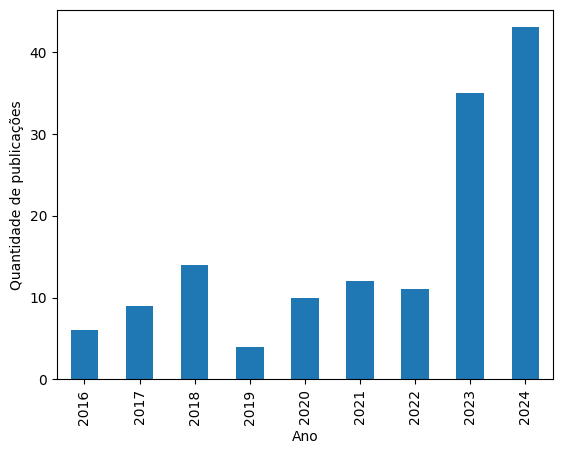

In [54]:
# Agrupando por ano
df_yearly = df.groupby('year').size()
ax = df_yearly.plot.bar()
ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade de publicações")
plt.savefig('/tmp/tertiary_review_yearly_barplot.pdf')

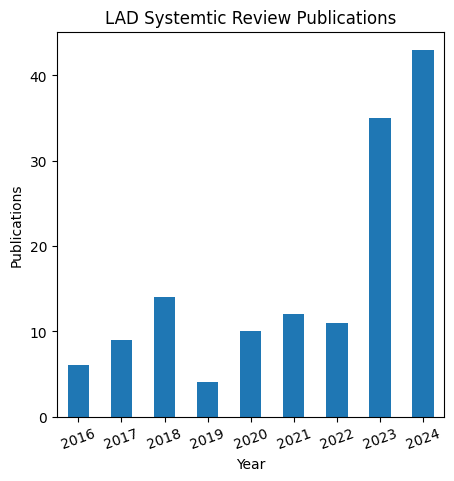

In [55]:
# a english version
df_yearly = df.groupby('year').size()
ax = df_yearly.plot.bar(title='LAD Systemtic Review Publications', figsize=(5, 5))
ax.set_xlabel("Year")

# rotacionando os anos
ax.set_xticklabels(df_yearly.index,rotation=20)

ax.set_ylabel("Publications")
plt.savefig('/tmp/tertiary_review_yearly_barplot_en.pdf')

In [56]:
# Salvando tabela em .tex
tertiary_review_databases = df.groupby('database').size().sort_values(ascending=False)
tertiary_review_databases = pd.DataFrame(tertiary_review_databases)
tertiary_review_databases.reset_index(inplace=True)
tertiary_review_databases.columns = ['Bases Selecionadas','Quantidade de publicações']

# soma
soma = tertiary_review_databases['Quantidade de publicações'].sum()
new_row = pd.DataFrame({'Bases Selecionadas': ['Soma'], 'Quantidade de publicações':[soma]})
tertiary_review_databases = pd.concat([tertiary_review_databases, new_row], axis=0, ignore_index=True)
tertiary_review_databases

,Bases Selecionadas,Quantidade de publicações
0,scopus,40
1,openalex,33
2,engineering village,22
3,web of science,18
4,eric,8
5,proquest,7
6,ieee,4
7,science direct,4
8,acm,3
9,wiley,3


In [57]:
# Salvando tabela em .tex
latex_code = pd.DataFrame(tertiary_review_databases).style.hide().to_latex(
    column_format="c|c", 
    position="H",
    label="table:tertiary_review_databases", 
    caption="Quantidade de publicações selecionadas em cada base",
    hrules=True, # necessita de \usepackage{booktabs},
    convert_css=True
) 

# manobra para colocar um linha horizontal antes da soma
latex_code_lines = latex_code.splitlines()
last_row_index = len(latex_code_lines) - 4
latex_code_lines.insert(last_row_index, '    \\hline')
modified_latex_code = '\n'.join(latex_code_lines)

with open('/tmp/tertiary_review_databases.tex', 'w') as the_file:
    the_file.write(modified_latex_code)

In [58]:
# parsif.al resultados

pl = pd.read_csv('../data/doutorado/tertiary_review/articles.csv')
for index, row in pl.iterrows():
    # limpando os títulos para fazermos uma comparação com bibtex mais suave
    pl.iloc[index,1] = ' '.join(pl.iloc[index,1].strip().split())

# criando uma coluna vazia chamada id_generico 
pl['id_generico'] = pd.Series(dtype='str')

In [59]:
# tentando ver um jeito de agregar o database do bibtex com o csv do parsifal

n = pl[pl['doi'].isnull()].shape[0]
print("Quantidade de artigos que estão sem doi no dataframe pl exportados do parsifal?", n)

n = df[df['doi'].isnull()].shape[0]
print("Quantidade de artigos que estão sem doi no dataframe df que foi criado a partir dos bibtex?", n)

n = df[df['issn'].isnull()].shape[0]
print("Quantidade artigos que estão sem issn no dataframe df que foi criado a partir dos bibtex?", n)

n = pl[pl['issn'].isnull()].shape[0]
print("Quantidade de artigos que estão sem issn no dataframe pl exportados do parsifal?", n)

n = df[ df['issn'].isnull() & df['doi'].isnull() ].shape[0]
print("Quantidade de artigos que estão sem issn e sem doi no dataframe df que foi criado a partir dos bibtex?", n)

n = pl[ pl['issn'].isnull() & pl['doi'].isnull() ].shape[0]
print("Quantidade de artigos que estão sem issn e sem doi no dataframe pl exportados do parsifal?",n)

n = sum(df["title"].isin(pl['title']) == False)
print("Quantidade de artigos que os títulos em df não estão em pl",n)

n = sum(pl["title"].isin(df['title']) == False)
print("Quantidade de artigos que os títulos em pl não estão em df",n)

n = sum(pl["title"].isin(df['title'])  )
print("Quantidade de artigos que os títulos em pl estão em df",n)

n = sum(df["title"].isin(pl['title']))
print("Quantidade de artigos que os títulos em df estão em pl",n)

n = sum(df["title"].isin(pl['title']) | df["doi"].isin(pl['doi']) | df["issn"].isin(pl['issn']))
print("Quantidade de artigos que os títulos, doi ou issn em df estão em pl",n)

n = sum(pl["title"].isin(df['title']) | pl["doi"].isin(df['doi']) | pl["issn"].isin(df['issn']))
print("Quantidade de artigos que os títulos, doi ou issn em pl estão em df",n)

print(" -- Assim percebemos que com título ou doi ou issn podemos juntar todos artigos -- ")

Quantidade de artigos que estão sem doi no dataframe pl exportados do parsifal? 46
Quantidade de artigos que estão sem doi no dataframe df que foi criado a partir dos bibtex? 46
Quantidade artigos que estão sem issn no dataframe df que foi criado a partir dos bibtex? 48
Quantidade de artigos que estão sem issn no dataframe pl exportados do parsifal? 49
Quantidade de artigos que estão sem issn e sem doi no dataframe df que foi criado a partir dos bibtex? 14
Quantidade de artigos que estão sem issn e sem doi no dataframe pl exportados do parsifal? 14
Quantidade de artigos que os títulos em df não estão em pl 11
Quantidade de artigos que os títulos em pl não estão em df 17
Quantidade de artigos que os títulos em pl estão em df 127
Quantidade de artigos que os títulos em df estão em pl 133
Quantidade de artigos que os títulos, doi ou issn em df estão em pl 144
Quantidade de artigos que os títulos, doi ou issn em pl estão em df 144
 -- Assim percebemos que com título ou doi ou issn podemos 

In [60]:
# Estratégia para juntar o dataframe df dos bibtex com o dataframe dos parsifal pl
# No df eu criei um coluna chamada id_generico
# Se eu identificar no dataframe do parsifal que ele é igual a uma linha especifica do df eu copio id_generico para pl 
id_coluna_id_generico_pl = np.where(pl.columns == 'id_generico')[0]
id_coluna_id_generico_pl = int(id_coluna_id_generico_pl[0])

id_coluna_id_generico_df = np.where(df.columns == 'id_generico')[0]
id_coluna_id_generico_df = int(id_coluna_id_generico_df[0])

for index, row in pl.iterrows():
    # procurando em df se tem doi igual no pl
    df_row = df[ (df['doi'] == row['doi']) ]
    if df_row.shape[0] > 0:
        # só me interessa o primeira ocorrência
        pl.iloc[index,id_coluna_id_generico_pl] = df_row.iloc[0,id_coluna_id_generico_df]
    else:
        df_row = df[ (df['issn'] == row['issn'])]
        if df_row.shape[0] > 0:
            pl.iloc[index,id_coluna_id_generico_pl] = df_row.iloc[0,id_coluna_id_generico_df]
        else:
            df_row = df[ (df['title'] == row['title'])]
            if df_row.shape[0] > 0:
                pl.iloc[index,id_coluna_id_generico_pl] = df_row.iloc[0,id_coluna_id_generico_df]
                
# criando um novo dataframe com df e pl                
df_completo = pd.merge(df, pl, how = 'inner', on = 'id_generico')

In [62]:
# artigos excluídos em latex
excluded_articles = df_completo.groupby(['selection_criteria']).size().sort_values(ascending=False)
excluded_articles = pd.DataFrame(excluded_articles)
excluded_articles.reset_index(inplace=True)
excluded_articles.columns = ['Motivo','Quantidade']

# soma
soma = excluded_articles['Quantidade'].sum()
new_row = pd.DataFrame({'Motivo': ['Soma'], 'Quantidade':[soma]})
excluded_articles = pd.concat([excluded_articles, new_row], axis=0, ignore_index=True)

# Salvando tabela em .tex
latex_code = pd.DataFrame(excluded_articles).style.hide().to_latex(
    column_format="c|c", 
    position="H",
    label="table:tertiary_review_excluded", 
    caption="Artigos excluídos",
    hrules=True,
    convert_css=True
) 

latex_code = latex_code.replace('\\\\\n', '\\\\ \\hline\n')

# manobra para colocar um linha horizontal antes da soma
latex_code_lines = latex_code.splitlines()
last_row_index = len(latex_code_lines) - 4
latex_code_lines.insert(last_row_index, '    \\hline')
modified_latex_code = '\n'.join(latex_code_lines)

with open('/tmp/tertiary_review_excluded.tex', 'w') as the_file:
    the_file.write(modified_latex_code)
excluded_articles

,Motivo,Quantidade
0,É uma revisão sistemática em Learning Analytic...,24
1,Não é um artigo,10
2,"É uma revisão sistemática em LAD, porém com ma...",5
3,"Não é um revisão sistemática, nem um estudo pr...",4
4,Estudo duplicado (descartado pois foi escolhid...,3
5,É um estudo primário sobre LAD e não uma revis...,3
6,"É uma revisão sistemática em LAD, mas não temo...",3
7,É um estudo primário sobre LA e não sobre LAD,2
8,"É uma revisão sistemática em LAD, mas não com ...",2
9,É uma revisão sistemática não relacionada a Le...,2


In [63]:
n = df_completo.shape[0]
print("Quantidade de artigos totais",n)

n = df_completo[df_completo['status'] == 'Duplicated'].shape[0]
print("Quantidade de artigos duplicados",n)

n = df_completo[df_completo['status'] != 'Duplicated'].shape[0]
print("Quantidade de artigos não duplicados",n)

Quantidade de artigos totais 144
Quantidade de artigos duplicados 75
Quantidade de artigos não duplicados 69


In [64]:
# Refazendo a tabela da quantidade de artigos por base de dados considerando os duplicados
df_duplicados = df_completo[df_completo['status'] == 'Duplicated']
df_nao_duplicados = df_completo[df_completo['status'] != 'Duplicated']
df_aceitos =  df_completo[df_completo['status'] == 'Accepted']

df_duplicados = pd.DataFrame(df_duplicados.groupby('database').size(), columns=['Duplicados'])
df_nao_duplicados = pd.DataFrame(df_nao_duplicados.groupby('database').size(), columns=['Não duplicados'])
df_aceitos = pd.DataFrame(df_aceitos.groupby('database').size(), columns=['Selecionados'])

df_databases = df_duplicados.combine_first(df_nao_duplicados)
df_databases = df_databases.combine_first(df_aceitos)
df_databases.reset_index(inplace=True)
df_databases = df_databases.sort_values(by='Não duplicados', ascending=False)

# convertendo para inteiro
df_databases['Duplicados'] = df_databases['Duplicados'].fillna(0)
df_databases['Selecionados'] = df_databases['Selecionados'].fillna(0)
df_databases['Duplicados'] = df_databases['Duplicados'].astype(int)
df_databases['Não duplicados'] = df_databases['Não duplicados'].astype(int)
df_databases['Selecionados'] = df_databases['Selecionados'].astype(int)

# soma
soma_duplicados = df_databases['Duplicados'].sum()
soma_nao_duplicados = df_databases['Não duplicados'].sum()
soma_aceitos = df_databases['Selecionados'].sum()
new_row = pd.DataFrame({'database': ['Soma'], 
                        'Duplicados':[soma_duplicados],
                        'Não duplicados':[soma_nao_duplicados],
                        'Selecionados':[soma_aceitos],
                       })
df_databases = pd.concat([df_databases, new_row], axis=0, ignore_index=True)

df_databases.columns = ['Bases','Duplicadas', 'Não duplicadas', 'Selecionadas']

# Salvando tabela em .tex
latex_code = pd.DataFrame(df_databases).style.hide().to_latex(
    column_format="c|c|c|c", 
    position="H",
    label="table:tertiary_review_databases_duplicated", 
    caption="Quantidade de publicações por base de busca com identificação de duplicados",
    hrules=True,
    convert_css=True
) 

# manobra para colocar um linha horizontal antes da soma
latex_code_lines = latex_code.splitlines()
last_row_index = len(latex_code_lines) - 4
latex_code_lines.insert(last_row_index, '    \\hline')
modified_latex_code = '\n'.join(latex_code_lines)

with open('/tmp/tertiary_review_databases_duplicated.tex', 'w') as the_file:
    the_file.write(modified_latex_code)

df_databases

,Bases,Duplicadas,Não duplicadas,Selecionadas
0,openalex,39,30,6
1,engineering village,21,10,1
2,scopus,6,8,0
3,web of science,0,6,0
4,proquest,2,4,0
5,science direct,0,4,0
6,ieee,4,3,0
7,eric,2,2,1
8,wiley,1,2,0
9,Soma,75,69,8


In [14]:
# lista dos aceitos
df_aceitos =  df_completo[df_completo['status'] == 'Accepted']
df_aceitos.columns #title_x #['title_x'

df_aceitos[['year_y','title_y','author_x', 'identifier','journal_x','journal_y','document_type' ]].sort_values(by=['year_y'], ascending=True)

,year_y,title_y,author_x,identifier,journal_x,journal_y,document_type
5,2021,Staying on target: A systematic literature rev...,"Valle, Natercia and Antonenko, Pavlo and Dawso...",valle2021,British Journal of Educational Technology,British Journal of Educational Technology,Journal Article
44,2021,The Current Landscape of Research and Practice...,"Liu, Min and Han, Songhee and Shao, Peixia and...",liu2021,NaN,NaN,Book Section
37,2023,"A checklist to guide the planning, designing, ...","Kaliisa, Rogers and Jivet, Ioana and Prinsloo,...",kaliisa1,International Journal of Educational Technolog...,International Journal of Educational Technolog...,Article
11,2023,Methods for Evaluating Learning Analytics and ...,"Tretow-Fish, Tobias and Khalid, Saifuddin",tretow-fish2023,The Electronic Journal of e-Learning,Electronic Journal of e-Learning,Article
40,2023,Use of Predictive Analytics within Learning An...,"Ramaswami, Gomathy and Sušnjak, Teo and Mathra...",ramaswami2022,Technology Knowledge and Learning,TECHNOLOGY KNOWLEDGE AND LEARNING,Review
64,2023,A Review of Learning Analytics Dashboard and a...,"Munim, Ziaul and Kim, Taeeun",munim2023,AHFE international,AHFE international,Journal Article
74,2024,Learning Analytics Dashboards for Advisors -- ...,"Vemula, Suchith Reddy and Moraes, Marcia",20240071151,arXiv,arXiv,NaN
137,2024,Learning analytics dashboards are increasingly...,"Paulsen, Lucas and Lindsay, Euan",paulsen_learning_2024,Education and Information Technologies,Education and Information Technologies,NaN


In [16]:
# salvando aceitos em latex
#df_aceitos_latex = df_aceitos[['year_y','title_y','author_x', 'identifier']].sort_values(by=['year_y'])
df_aceitos_latex = df_aceitos[['title_y', 'identifier','year_y']].sort_values(by=['year_y'], ascending=True)
df_aceitos_latex['id'] = range(1, len(df_aceitos_latex) + 1)
                                                                 
df_aceitos_latex.columns = ['Título', 'Referência','Ano','id']

df_aceitos_latex['Referência'] = '\citet{' + df_aceitos_latex['Referência'] + '}'

df_aceitos_latex = df_aceitos_latex[['id','Título', 'Referência']]

# Salvando tabela em .tex
latex_code = pd.DataFrame(df_aceitos_latex).style.hide().to_latex(
    column_format="c|c|c|", 
    position="H",
    label="table:tertiary_review_accepted_list", 
    caption="Publicações selecionadas na revisão terciária",
    hrules=True,
    convert_css=True
)

# manobra para colocar linhas horizontais
latex_code = latex_code.replace('\\\\\n', '\\\\ \\hline\n')

with codecs.open('/tmp/tertiary_review_accepted_list.tex', 'w', 'utf-8') as the_file:
    the_file.write(latex_code)
df_aceitos_latex

,id,Título,Referência
5,1,Staying on target: A systematic literature rev...,\citet{valle2021}
44,2,The Current Landscape of Research and Practice...,\citet{liu2021}
37,3,"A checklist to guide the planning, designing, ...",\citet{kaliisa1}
11,4,Methods for Evaluating Learning Analytics and ...,\citet{tretow-fish2023}
40,5,Use of Predictive Analytics within Learning An...,\citet{ramaswami2022}
64,6,A Review of Learning Analytics Dashboard and a...,\citet{munim2023}
74,7,Learning Analytics Dashboards for Advisors -- ...,\citet{20240071151}
137,8,Learning analytics dashboards are increasingly...,\citet{paulsen_learning_2024}


In [16]:
# montar um bibtex só com os aceitos - não consegui, ainda!

In [17]:
# vou criar uma coluna só dos duplicados
df_completo['classificação'] = df_completo['status']
df_completo['status'] = df_completo['status'].str.replace('Accepted','Não Duplicado')
df_completo['status'] = df_completo['status'].str.replace('Duplicated','Duplicado')
df_completo['status'] = df_completo['status'].str.replace('Rejected','Não Duplicado')

porcentagem_duplicados = 100* (sum(df_completo['status'] == 'Duplicado')/df_completo.shape[0])
porcentagem_duplicados

52.083333333333336

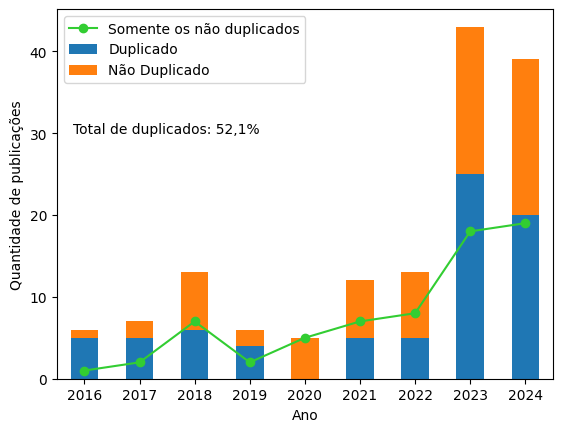

In [18]:
# Gráfico de barras empilhado, considerando os duplicados
ax = df_completo.groupby(['year_x', 'status']).size().unstack().plot(kind='bar', stacked=True)

# Adicionando uma linha desconsiderando os duplicados
nao_duplicados = df_completo.groupby(['year_x', 'status']).size().unstack()
nao_duplicados['Somente os não duplicados'] = nao_duplicados['Não Duplicado']
nao_duplicados['Somente os não duplicados'].plot(linestyle='-', marker='o', color=["limegreen"], ax=ax)

ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade de publicações")
#ax.text(-0.2, 30, "Total de duplicados: {:.2f}%".format(porcentagem_duplicados))
ax.text(-0.2, 30, "Total de duplicados: 52,1%")
ax.legend().set_title("")
plt.savefig('/tmp/tertiary_review_yearly_barplot.pdf')

In [19]:
# artigos que fiz algum tipo de comentário

comments = df_completo[df_completo['comments'].notnull()]
comments[ ['title_x','comments'] ]

,title_x,comments
48,A Current Overview of the Use of Learning Anal...,Esse também é uma revisão terciária
67,Learning analytics and tech-tools: Insights of...,"Esse artigo, diferentes de diversos outros, el..."
111,Visual Learning Analytics for Educational Inte...,Neste artigo ao invés de chamar de LAD - Learn...
130,Research Trends in Teaching Analytics: Bibliom...,Neste artigo é apresnetado uma ramificação nov...


## 3. Planejamento: Definição dos critérios de inclusão e de exclusão

Neste trabalho vamos usar somente critérios de exclusão, que são: 

- Texto duplicado (indexado em mais de uma bases de dados) - Não usado, pois o parsifal tem a opção "Duplicated"
- Estudo duplicado (descartado pois foi escolhido o texto mais recente e completo)
- É um estudo primário sobre LAD e não uma revisão sistemática
- É um estudo primário sobre LA e não sobre LAD
- É um estudo primário não relacionado a Learning Analytics ou LAD
- É uma revisão sistemática em Learning Analytics, mas não focada apenas em LAD
- É uma revisão sistemática não relacionada a Learning Analytics ou LAD
- Não temos acesso ao texto completo
- Não é um artigo
- Não é uma revisão sistemática nem um estudo primário sobre LA ou LAD
- É uma revisão sistemática em LAD, porém com mais de 5 anos

## 4. Condução Busca Sistemática e Seleção de Estudos



    

    
    


## 5. Condução: Extração de Dados

    
- Agentes educacional do LAD: estudantes, docentes, gestores, técnicos e sociedade
- Quais bases de dados foram consultadas
- Em qual ano os artigos foram coletados para a revisão sistemática?
- Qual ferramenta foi utilizada para a revisão sistemática?
- Número de artigos inicialmente selecionados?
- Número de artigos incluídos na análise final?
- Contexto de uso do LAD: Aula presencial usando LMS como suporte, Ensino remoto, MOOC ou Não Especificado.
- Tipo do LAD avaliado na revisão: adaptable LADs, adaptive LADs, fundamentos educacionais,


## 6. Condução: Síntese e Análise dos Dados

- Não foram em nenhum aspecto em particular de LAD: 6
- Avalaliaram se houve fundamentos teóricos educacionais na implementação do LAD: 6
- Avalaliaram efetividade no ganho educacional com LAD: 2
- Avalaliaram LAD implementados com uso de Aprendizado de Máquina: 1


## 7. Condução: Avaliação da Qualidade

- A metodologia usada na revisão sistemática foi descrita de forma completa e clara?
- O artigo fornece informações para torna-lo reprodutível?
- O artigo informa se uma ferramenta de suporte foi utilizada na revisão sistemática?
- O artigo deixa claro os agentes educacionais alvo do LAD?
- O artigo indica o intervalo de tempo considerado para a seleção dos estudos?


## 8. Resultados: Interpretação dos Resultados


## 9. Resultados: Relato dos Resultados